In [2]:
import os
from pathlib import Path

from ansys.heart.misc.downloader import download_case, unpack_case
import ansys.heart.preprocessor.models as models

import pyvista
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation

from vtkmodules.vtkCommonDataModel import vtkIterativeClosestPointTransform

os.environ["USE_OLD_HEART_MODELS"] = "1"

__file__ = r"c:\Users\xuhu\pyheart-lib\examples\preprocessor\doc_ECG_coordinates,py"

case_file = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "01.case")
)
download_folder = str(Path(Path(__file__).resolve().parents[2], "downloads"))
workdir = str(
    Path(Path(__file__).resolve().parents[2], "downloads", "Strocchi2020", "01", "Biv")
)
path_to_model = str(Path(workdir, "heart_model.pickle"))


if not os.path.isfile(case_file):
    path_to_downloaded_file = download_case(
        "Strocchi2020", 1, download_folder=download_folder, overwrite=False
    )
    unpack_case(path_to_downloaded_file)


info = models.ModelInfo(
    database="Strocchi2020",
    path_to_case=case_file,
    work_directory=workdir,
    path_to_model=path_to_model,
    add_blood_pool=False,
    mesh_size=1.5,
)


# create the working directory
info.create_workdir()
# clean the working directory
info.clean_workdir(extensions_to_remove=[".stl", ".vtk", ".msh.h5"])
# dump information to stdout
info.dump_info()

# instantiate a four chamber model
model = models.BiVentricle(info)

# extract the simulation mesh
model.extract_simulation_mesh()

# dump the model to disk for future use
model.dump_model(path_to_model)
# print the resulting information
model.print_info()

2023/10/02 16:36:16 - DEBUG - Establishing tetra-face connectivity...
2023/10/02 16:36:47 - DEBUG - Time elapsed: 30.9 s
2023/10/02 16:36:47 - DEBUG - Skipping interface pair: Left ventricle myocardium | Right ventricle myocardium
2023/10/02 16:36:49 - DEBUG - Extracting : ['epicardium', 'endocardium', 'septum'] from left-ventricle-myocardium
2023/10/02 16:36:49 - DEBUG - Extracting : ['epicardium', 'endocardium'] from right-ventricle-myocardium
2023/10/02 16:36:52 - INFO - Remeshing volume...
2023/10/02 16:36:54 - DEBUG - Starting meshing in directory: C:\Users\xuhu\pyheart-lib\downloads\Strocchi2020\01\Biv\meshing



Importing one geom object per program-controlled and one zone per body ...
    C:\\Program Files\\ANSYS Inc\\v222\\commonfiles\\CPython\\3_7\\winx64\\Release\\python\\..\\Ansys\\TGrid\\CADReaders.py started by xuhu on LYOTRAINEE14 winx64 on Mon Oct  2 16:37:22 2023
    using Python 3.7.13 (remotes/origin/bdighole/python/3713/clean_up-dirty:d4e1bece, Apr  6 2022, 00:24:) [MSC v.1920 64 bit (AMD64)]
    
    using Ansys.Meshing.FieldMesher build May 27 2022 08:47:51
    
    running ANSYS TGrid CADToTGridConverter ...
    setting up parameters ...
    setting up parameters done.
    running conversion ...
    converting 9 file(s) from Workbench to FLTG using output path 'C:\\Users\\xuhu\\AppData\\Local\\Temp/out169625744173452.tgf'
    converting file 'part_left-ventricle-endocardium.stl' (1 of 9) from Workbench to FLTG using output path 'C:\\Users\\xuhu\\AppData\\Local\\Temp'
    importing data ...
    importing meshing model in STL format from file 'C:\\Users\\xuhu\\pyheart-lib\\downl

2023/10/02 16:38:14 - DEBUG - Excluding 4 array names
2023/10/02 16:38:14 - DEBUG - Removing cell data...uvc_intraventricular
2023/10/02 16:38:14 - DEBUG - Removing cell data...uvc_longitudinal
2023/10/02 16:38:14 - DEBUG - Removing cell data...uvc_rotational
2023/10/02 16:38:14 - DEBUG - Removing cell data...uvc_transmural
2023/10/02 16:38:14 - WARNING - Normalization of vectors is buggy and turned off
2023/10/02 16:38:14 - WARNING - Removed returning cell / point data
2023/10/02 16:38:19 - DEBUG - Excluding 5 array names
2023/10/02 16:38:19 - DEBUG - Removing cell data...electrode_endo_rv
2023/10/02 16:38:19 - DEBUG - Removing cell data...uvc_intraventricular
2023/10/02 16:38:19 - DEBUG - Removing cell data...uvc_longitudinal
2023/10/02 16:38:19 - DEBUG - Removing cell data...uvc_rotational
2023/10/02 16:38:19 - DEBUG - Removing cell data...uvc_transmural
2023/10/02 16:38:19 - DEBUG - Removing point data...fiber
2023/10/02 16:38:19 - DEBUG - Removing point data...sheet
2023/10/02 16:

In [80]:

file_path = "C:/Users/xuhu/pyvista_test/2019_Lopez_torsoPAP_tetraVol-Labeled/torsoPAP_tetraVol-Labeled_ORIGINAL_full.vtk"
torso = pyvista.read(file_path)

Organids_array = torso["OrganID"]
organ_id_to_plot = 7
# ribs = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")
heart = torso.threshold([organ_id_to_plot - 0.1, organ_id_to_plot + 0.1], scalars="OrganID")


In [89]:
fix_points = []

# Iterate over caps in the left ventricle
for cap in model.left_ventricle.caps:
    fix_points.append(cap.centroid)

# Iterate over caps in the right ventricle
for cap in model.right_ventricle.caps:
    fix_points.append(cap.centroid)

# Iterate over apex points in the left ventricle
for apex in model.left_ventricle.apex_points:
    fix_points.append(apex.xyz)

# Iterate over apex points in the right ventricle
for apex in model.right_ventricle.apex_points:
    fix_points.append(apex.xyz)

# Convert the list of points to a NumPy array
fix_points = np.array(fix_points)


In [91]:
fix_points

array([[  4.20857519, 118.32163226, 391.43196981],
       [ 15.04158011, 139.09469458, 381.88963037],
       [ 11.89445634,  95.82599368, 423.84591809],
       [-22.98204015,  92.93555511, 363.03724758],
       [ 67.26314232,  76.51744761, 352.68705118],
       [ 70.05125821,  71.62641545, 352.42993226],
       [ 45.41901794,  78.01370688, 333.33936308],
       [ 47.67597045,  76.44610331, 331.14411229]])

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


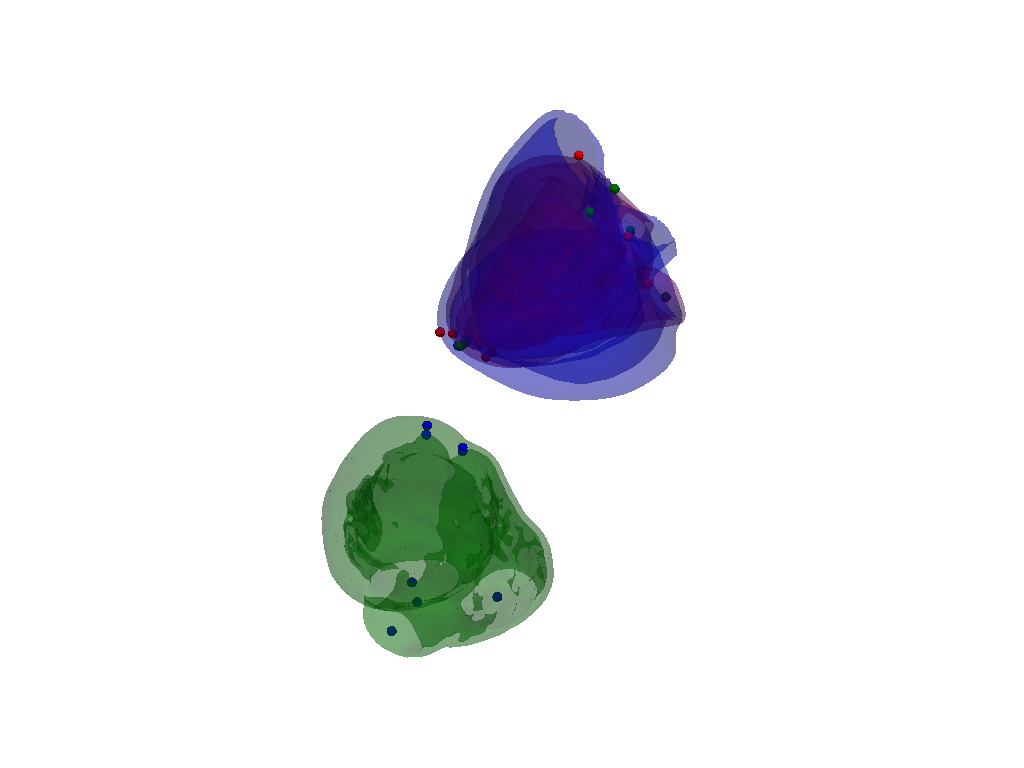

In [92]:

# --------------------------Use rigid transform--------------------------


"""
mitral-valve [ 14.78575795 138.72218537 381.66334608]
aortic-valve [  4.20356264 118.41931813 391.46262272]
tricuspid-valve [-23.12532785  92.6664522  363.28210652]
pulmonary-valve [ 11.8208042   95.51631782 424.01633795]
left_ventricle apex:  [ 66.98953175  76.04045288 353.25812367]
left_ventricle apex:  [ 70.91348565  72.35403913 352.7457911 ]
right_ventricle apex:  [ 45.9829824   77.48032215 333.94426975]
right_ventricle apex:  [ 47.77539122  77.14911944 331.0164472 ]
"""

move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367], # mitral-valve
    [94.35242091, 75.99022315, 213.31654731], # aortic-valve
    [67.14045655, 102.49380179, 216.20654707], # tricuspid-valve
    [121.58912558, 89.76497459, 223.29557159], # pulmonary-valve
    [70.87069056682236, 84.83837198547876, 295.6765864478138], # left endo
    [70.54655746919204, 84.50457846174797, 297.2737993295601], # left epi
    [76.04229182019685, 66.53094359081156, 297.7182142431582], # right endo
    [75.08606835375224, 66.33759424571653, 302.2811669120656], # right epi   
])

moving_model = heart

# Define the initial transformation parameters
random_quaternion = Rotation.random().as_quat()
initial_params = np.zeros(7)
initial_params[:3] = np.random.rand(3)  # Random translation
initial_params[3:] = random_quaternion

# Constrain quaternion components to ensure they remain valid
constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

# Define the rigid transform function
def rigid_transform(params, points):
    translation = params[:3]
    quaternion = params[3:]
    quaternion /= np.linalg.norm(quaternion)
    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    transformed_points = np.dot(points - translation, rotation_matrix.T)
    return transformed_points

# Define the objective function
def objective_function(params, fixed_points, moving_points):
    transformed_points = rigid_transform(params, moving_points)
    distance = np.sum(np.square(transformed_points - fixed_points))
    return distance

# 进行最小化优化
result = minimize(objective_function, initial_params, args=(fix_points, move_points), method='L-BFGS-B', constraints=constraints)

# 获取最优参数
optimal_params = result.x

# 获取刚性变换后的移动模型点云
transformed_move_points = rigid_transform(optimal_params, move_points)

# 创建PyVista点云对象
fix_cloud = pyvista.PolyData(fix_points)
move_cloud = pyvista.PolyData(move_points)
transformed_move_cloud = pyvista.PolyData(transformed_move_points)

# 显示固定和移动模型以及配准后的模型
p2 = pyvista.Plotter()
p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

# Visualize the original moving model and the transformed model
p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)



# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


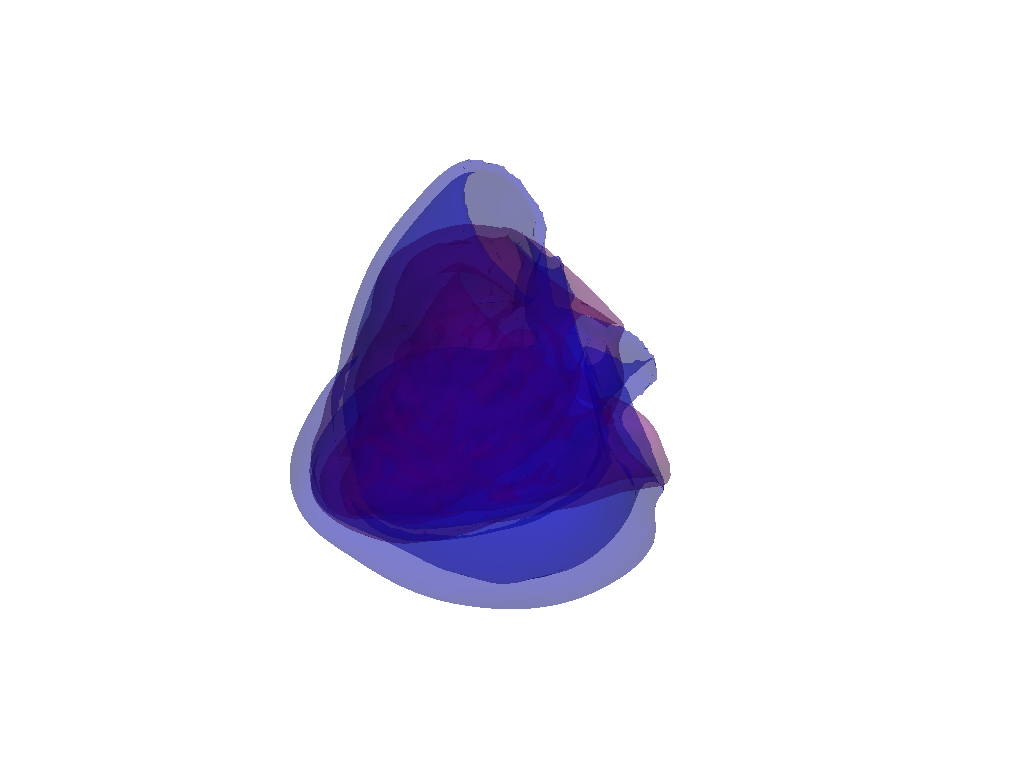

In [93]:
# 显示固定和移动模型以及配准后的模型
p2 = pyvista.Plotter()
# Visualize the original moving model and the transformed model
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)


# # Set camera position
# p2.camera_position = 'xy'
# p2.camera.azimuth = 10.0

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

## GetLandmarkTransform

In [94]:
# moving_model = transformed_model.copy()
mesh_a = transformed_model.copy() # moving model
mesh_b = model.mesh.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(100)
icp.SetMaximumMeanDistance(0.000001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()


aligned = mesh_a.transform(icp.GetMatrix())



c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


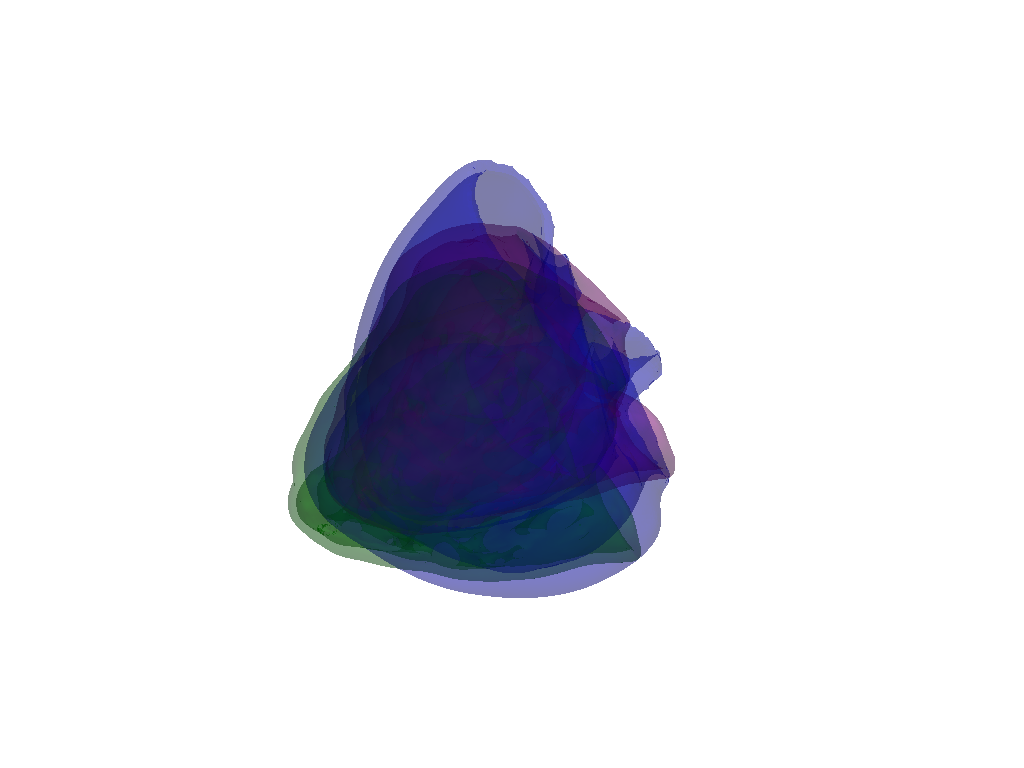

In [95]:
p2 = pyvista.Plotter()

# Visualize the original moving model and the transformed model
# p2.add_mesh(model.mesh, color="blue", opacity=0.1)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="green", opacity=0.3) 

# # Set camera position
# p2.camera_position = 'xy'
# p2.camera.azimuth = 10.0

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


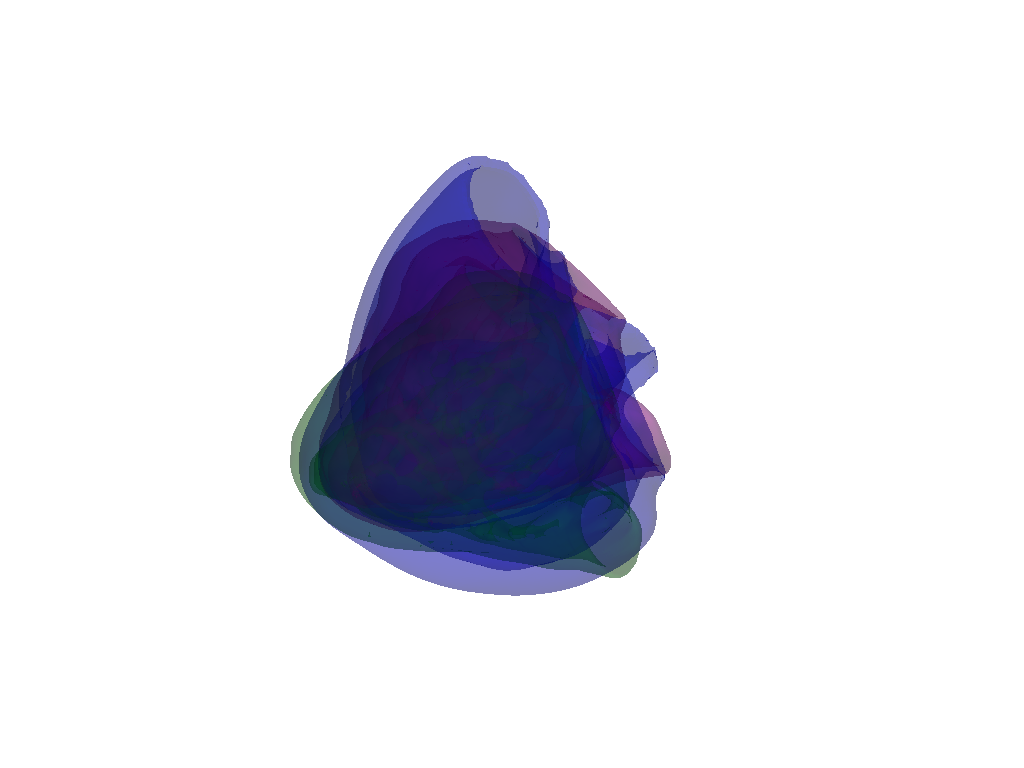

In [96]:
# moving_model = transformed_model.copy()
mesh_a = transformed_model.copy() # moving model
mesh_b = model.mesh.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(1000)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()


aligned = mesh_a.transform(icp.GetMatrix())

p2 = pyvista.Plotter()

p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3) # orginal model
p2.add_mesh(aligned, color="green", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()


In [97]:
import vtk

# moving_model = transformed_model.copy()


# p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)



mesh_a = transformed_move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.000001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()


# 获取变换矩阵
transformation_matrix = icp.GetMatrix()

# 创建 vtkTransform 对象并应用变换
transform = vtk.vtkTransform()
transform.SetMatrix(transformation_matrix)
# Assuming trans_model is a PyVista UnstructuredGrid object
trans_model = transformed_model.copy()

# Create a PyVista transform object
vtk_transform = vtk.vtkTransform()
vtk_transform.SetMatrix(icp.GetMatrix())

# Apply the transformation to the PyVista mesh
trans_model.transform(vtk_transform)

# aligned = mesh_a.transform(icp.GetMatrix())




UnstructuredGrid (0x1c626542c40)
  N Cells:    2714010
  N Points:   709914
  X Bounds:   -3.331e+01, 6.911e+01
  Y Bounds:   6.066e+01, 1.566e+02
  Z Bounds:   3.182e+02, 4.310e+02
  N Arrays:   2

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


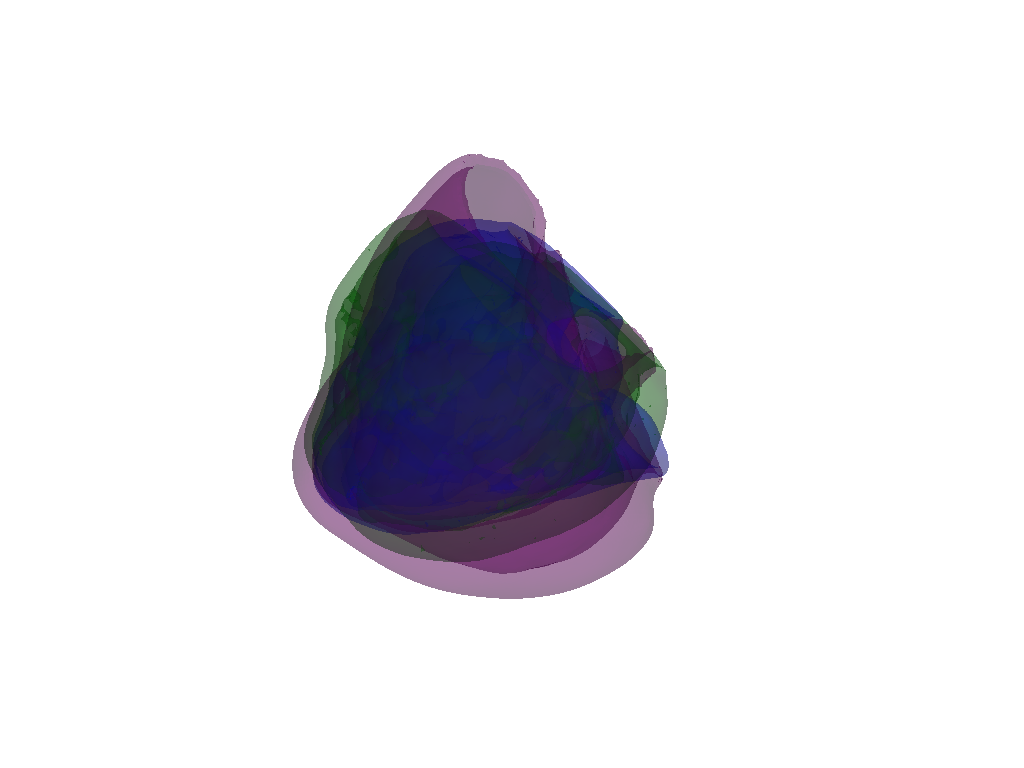

In [98]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="purple", opacity=0.3)
p2.add_mesh(transformed_model, color="blue", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="green", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

## without apex

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


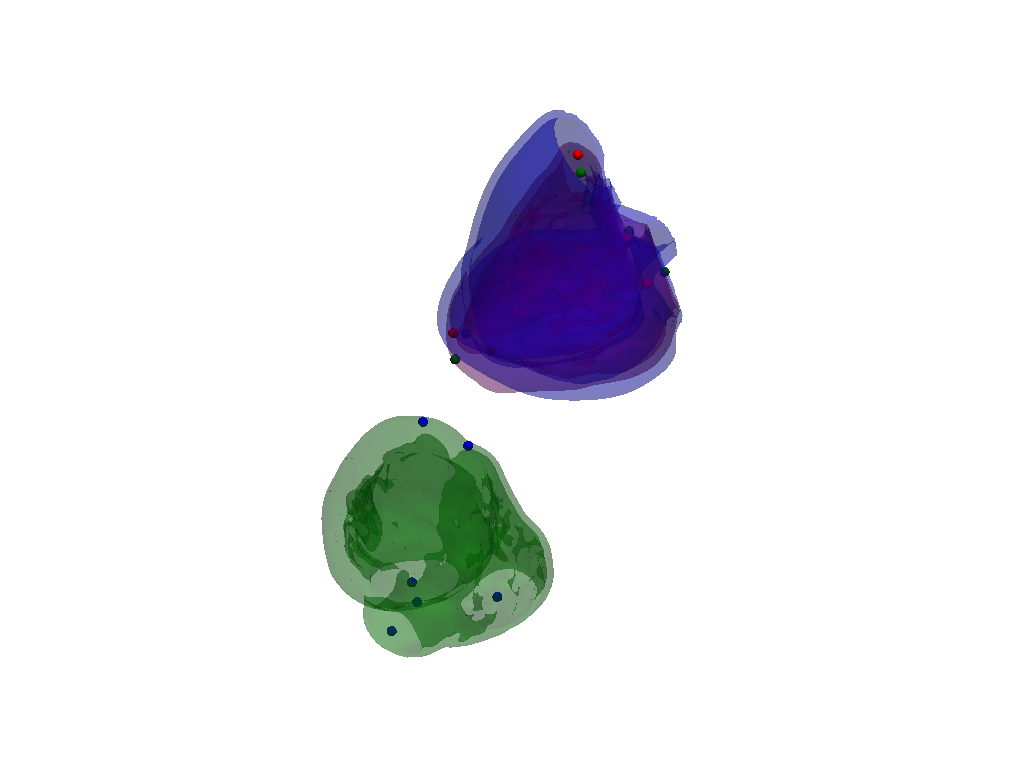

In [86]:

# --------------------------Use rigid transform--------------------------

# 生成固定和移动模型的点云数据
fix_points = np.array([
    [14.83343254, 138.84328635, 381.69040887],
    [4.05351488, 118.41811815, 391.29761896],
    [-23.05345085, 92.81499077, 363.12556701],
    [12.11718736, 95.61561885, 424.1137484],
    [66.62810203, 76.12861982, 352.41549411],
    [45.85018296, 77.32545243, 333.88303795],
])

move_points = np.array([
    [81.90321388, 57.90000882, 205.76663367],
    [94.35242091, 75.99022315, 213.31654731],
    [67.14045655, 102.49380179, 216.20654707],
    [121.58912558, 89.76497459, 223.29557159],
    [67.23725112873248, 84.63169515538843, 296.5102709741695],
    [74.54353173118157, 63.020954005473115, 302.25073384261583],
])

moving_model = heart

# Define the initial transformation parameters
random_quaternion = Rotation.random().as_quat()
initial_params = np.zeros(7)
initial_params[:3] = np.random.rand(3)  # Random translation
initial_params[3:] = random_quaternion

# Constrain quaternion components to ensure they remain valid
constraints = ({'type': 'eq', 'fun': lambda params: 1.0 - np.sum(params[3:] ** 2)})

# Define the rigid transform function
def rigid_transform(params, points):
    translation = params[:3]
    quaternion = params[3:]
    quaternion /= np.linalg.norm(quaternion)
    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    transformed_points = np.dot(points - translation, rotation_matrix.T)
    return transformed_points

# Define the objective function
def objective_function(params, fixed_points, moving_points):
    transformed_points = rigid_transform(params, moving_points)
    distance = np.sum(np.square(transformed_points - fixed_points))
    return distance

# 进行最小化优化
result = minimize(objective_function, initial_params, args=(fix_points, move_points), method='L-BFGS-B', constraints=constraints)

# 获取最优参数
optimal_params = result.x

# 获取刚性变换后的移动模型点云
transformed_move_points = rigid_transform(optimal_params, move_points)

# 创建PyVista点云对象
fix_cloud = pyvista.PolyData(fix_points)
move_cloud = pyvista.PolyData(move_points)
transformed_move_cloud = pyvista.PolyData(transformed_move_points)

# 显示固定和移动模型以及配准后的模型
p2 = pyvista.Plotter()
p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

# Visualize the original moving model and the transformed model
p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
p2.add_mesh(model.mesh, color="blue", opacity=0.3)



# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

In [87]:
import vtk

# moving_model = transformed_model.copy()


# p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)



mesh_a = transformed_move_cloud.copy() # moving model
mesh_b = fix_cloud.copy() #  fixed moded

icp = vtkIterativeClosestPointTransform()
icp.SetSource(mesh_a)
icp.SetTarget(mesh_b)

# Adjust parameters
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(1000)
icp.SetMaximumMeanDistance(0.0001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()


# 获取变换矩阵
transformation_matrix = icp.GetMatrix()

# 创建 vtkTransform 对象并应用变换
transform = vtk.vtkTransform()
transform.SetMatrix(transformation_matrix)
# Assuming trans_model is a PyVista UnstructuredGrid object
trans_model = transformed_model.copy()

# Create a PyVista transform object
vtk_transform = vtk.vtkTransform()
vtk_transform.SetMatrix(icp.GetMatrix())

# Apply the transformation to the PyVista mesh
trans_model.transform(vtk_transform)

# aligned = mesh_a.transform(icp.GetMatrix())




UnstructuredGrid (0x1c62660e700)
  N Cells:    2714010
  N Points:   709914
  X Bounds:   -3.165e+01, 8.074e+01
  Y Bounds:   5.854e+01, 1.586e+02
  Z Bounds:   3.325e+02, 4.260e+02
  N Arrays:   2

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


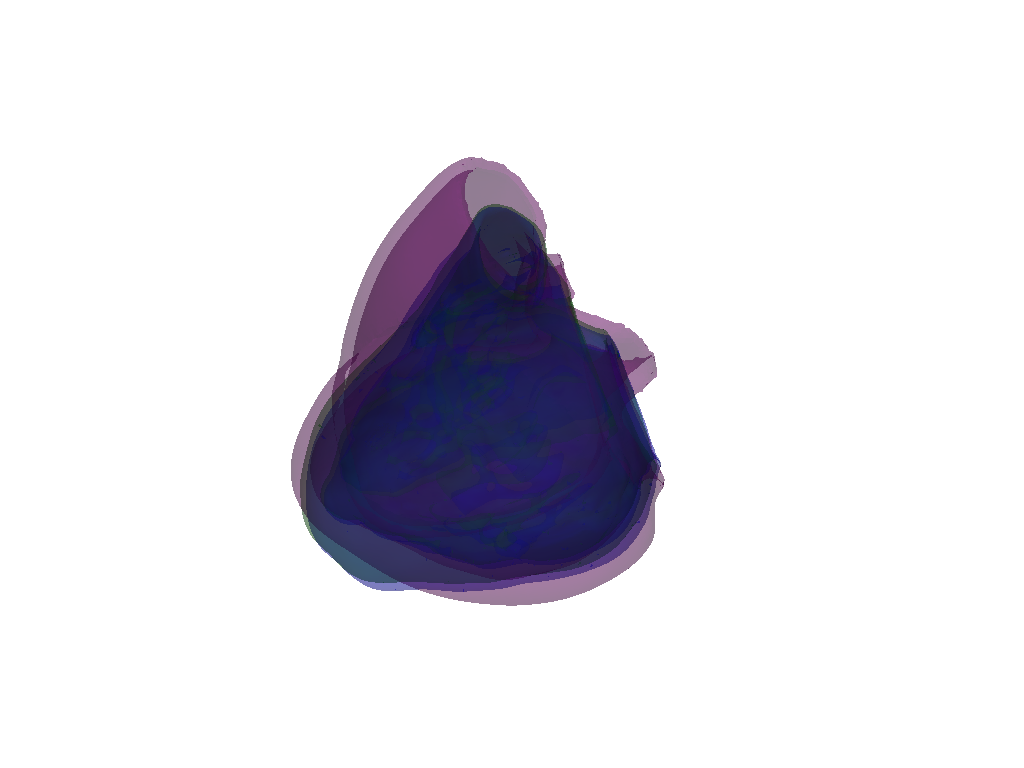

In [88]:
p2 = pyvista.Plotter()

p2.add_mesh(model.mesh, color="purple", opacity=0.3)
p2.add_mesh(transformed_model, color="blue", opacity=0.3) # orginal model
p2.add_mesh(trans_model, color="green", opacity=0.3) 

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()

c:\Users\xuhu\pyheart-lib\myenv38\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


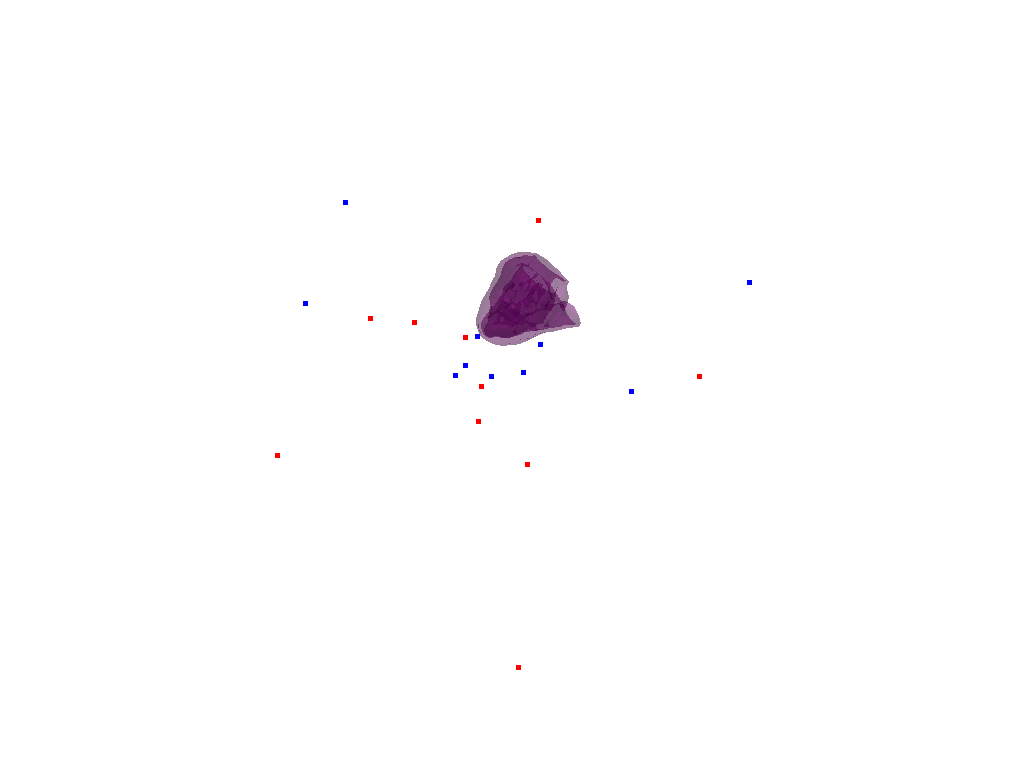

In [101]:
# 显示固定和移动模型以及配准后的模型
p2 = pyvista.Plotter()
# p2.add_mesh(fix_cloud, color="red", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(move_cloud, color="blue", point_size=10, render_points_as_spheres=True)
# p2.add_mesh(transformed_move_cloud, color="green", point_size=10, render_points_as_spheres=True)

# Get the optimized parameters
optimal_params = result.x

# Apply the optimal transformation to the moving model
transformed_model = moving_model.copy()
transformed_model.points = rigid_transform(optimal_params, moving_model.points)

electrode_positions = np.array([
    [x, y, z] for x, y, z in [
        [91.69106809237354, 167.4055272828183, 251.0416838617331],  # V1
        [114.07772933063883, 123.13918227704727, 291.5674747053013],  # V2
        [97.01364431022192, 109.7927312489943, 317.44575378942824],  # V3
        [81.88880486815538, 71.3859176743268, 349.4243690358569],  # V4
        [98.99550734014053, 15.879947224122954, 348.26233938958114],  # V5
        [106.23537044908527, -44.085603837273695, 329.16199248487465],  # V6
        [170.75567690191764, 234.51300755277248, 77.85629801985534],  # RA
        [262.9539413249434, -2.9189733795951724, 261.5745131716608],  # LA
        [-134.9640236606803, 197.05542132895272, 257.6409644703581],  # RL
        [-70.4506948627224, 22.20437217827933, 400.2792599184596]  # LL
    ]
])

transformed_electrodes = rigid_transform(optimal_params, electrode_positions)

# Visualize the original moving model and the transformed model
# p2.add_mesh(moving_model, color="green", opacity=0.3)
p2.add_mesh(transformed_model, color="purple", opacity=0.3)
# p2.add_mesh(model.mesh, color="blue", opacity=0.3)
p2.add_mesh(transformed_electrodes, color="blue", opacity=1)
# p2.add_mesh(electrode_positions, color="red", opacity=1)

# Set the background color and show the plotter
p2.background_color = "white"
p2.show()